In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [15]:
# sync the GW folder from m100 to the ismhpc
dry_run = True
rsync_str = "rsync -rDzv --exclude={'*_fragment*','*_fragments_*','*wfc*','*.dat','.ipynb_checkpoints'} "
if dry_run: rsync_str += '-n '
ssh_str = '-e ssh m100:/m100/home/userexternal/mdaless1/work/Xenes/Stanene/GW_analysis '
dest_path = 'GW_analysis'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)

rsync -rDzv --exclude={'*_fragments*','*_fragments_*','*wfc*','*.dat','.ipynb_checkpoints'} -n -e ssh m100:/m100/home/userexternal/mdaless1/work/Xenes/Stanene/GW_analysis '/m100_work/IscrC_PrExIn/Stanene/GW_analysis'


In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='slownodes',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'slownodes',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [5]:
# RunRules for m100
nodes = 16 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PrExIn',
                memory='240GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 16,
 'ntasks_per_node': 4,
 'cpus_per_task': 32,
 'omp_num_threads': 8,
 'gpus_per_node': 4,
 'memory': '240GB',
 'time': '23:59:00',
 'partition': 'm100_usr_prod',
 'account': 'IscrC_PrExIn',
 'qos': None,
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

# GW convergence analysis for Plumbene monolayer

We perform a convergence study for the GW runlevel

## HF Analysis

We do not repeat the convergence tests on the rim and Coulomb cutoff and we directly set
the values of the converged parameters found in the analysis of the other Xenes

* RandGVec = 200
* RandQPpts = 5000000

### HF convergence analysis for the cutoff in the exchange term

We study the convergence of the HF calculations in terms of the cutoff in the exchange term.

This analysis is performed with a 18x18x1 k-points sampling using the converged results for RIM and Coulomb cutoff.

__Note that we apply the cutoff on the EXXRLvcs variable while the VXCRLvcs is left to its DFT value__

In [4]:
input_dir = 'DFT_analysis/kpoints_18-nbnds_30.save'
run_dir = 'MB_analysis/kpoints_18-nbnds_30'

Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder GW_analysis-ONCV/kpoints_18-nbnds_30/SAVE already present. No operations performed.


We the define the input variables commmon to all the runs

In [5]:
start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index, K_index = 1, 37
RandGvec = 200
Randqpts = 5e6

EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)
inp

{'args': 'yambo -r -x -V all',
 'folder': 'GW_analysis-ONCV/kpoints_18-nbnds_30',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'HF_and_locXC'],
 'variables': {'StdoHash': [40.0, ''],
  'Nelectro': [28.0, ''],
  'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'OccTresh': [1e-05, ''],
  'NLogCPUs': [0.0, ''],
  'MEM_tresh': [51200.0, 'Kb'],
  'FFTGvecs': [23133.0, 'RL'],
  'SE_Threads': [0.0, ''],
  'RandQpts': [5000000.0, ''],
  'RandGvec': [200, 'RL'],
  'IDEm1Ref': [0.0, ''],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'EXXRLvcs': [159161.0, 'RL'],
  'VXCRLvcs': [159161.0, 'RL'],
  'DBsIOoff': 'none',
  'DBsFRAGpm': 'none',
  'PAR_def_mode': 'balanced',
  'CUTGeo': 'slab z',
  'Em1Anys': [[0.0, 0.0, 0.0], ''],
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'QPkrange': [[1, 37, 28, 29], ''],
  'QPerange': [[1, 37, 0.0, '-1.000000'], '']}}

We perform a convergence run on the EXXRLvcs parameter

In [6]:
study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

EXXRLvcs = [10.,20.,30.,40.,50.,60.] # Ha

# append runs for the Gamma point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-G-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(Gamma_index,Gamma_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-K-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(K_index,K_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 2 parallel tasks


In [7]:
#study.runs[0]

In [ ]:
results = study.run()

We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [10]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
#gap_G,gap_K

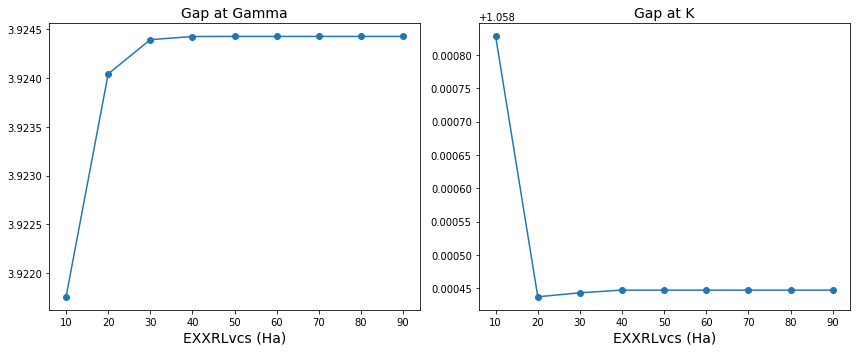

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(EXXRLvcs,gap_G)
axes[0].scatter(EXXRLvcs,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('EXXRLvcs (Ha)',size=14)
axes[1].plot(EXXRLvcs, gap_K)
axes[1].scatter(EXXRLvcs,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('EXXRLvcs (Ha)',size=14)
fig.tight_layout()

On the basis of this analysis we choose the converged value of the cutoff for exchange as

EXXRLvcs = 40 Ha

### HF Analysis in function of the k-points sampling

We test the convergence of the HF gap at $K$ and at the $\Gamma$ points in funciont of the dimension of the $k$-points sampling.

The converged parameters for the RIM and Coulomb cutoff and for the cutoff on the exchange derived in the previous analysis will be used.

In [30]:
RandQpts = 5000000
RandGvec = 200 

start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index = {18:1,30:1,42:1,60:1,72:1}
K_index = {18:37,30:91,42:169,60:331,72:469}

EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

In [31]:
kpoints = [18,30,42,60]

In [32]:
study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    input_dir = 'DFT_analysis/kpoints_%s-nbnds_30.save'%k
    run_dir = 'GW_analysis/kpoints_%s-nbnds_30'%k
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)
    
    inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs) #,VXCRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
    
    # append run at G
    idd = 'hf-G-kpoints_%s'%k
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff'])
    # append run at K
    idd = 'hf-K-kpoints_%s'%k
    inp.set_kRange(K_index[k],K_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff'])

Initialize a Dataset with 2 parallel tasks
SAVE folder GW_analysis-ONCV/kpoints_18-nbnds_30/SAVE already present. No operations performed.
SAVE folder GW_analysis-ONCV/kpoints_30-nbnds_30/SAVE already present. No operations performed.
SAVE folder GW_analysis-ONCV/kpoints_42-nbnds_30/SAVE already present. No operations performed.
SAVE folder GW_analysis-ONCV/kpoints_60-nbnds_30/SAVE already present. No operations performed.
SAVE folder GW_analysis-ONCV/kpoints_72-nbnds_30/SAVE already present. No operations performed.


In [33]:
#study.runs[0]

In [34]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]] 

Run the task [0, 1] 
Skip the run of hf-G-kpoints_18
Skip the run of hf-K-kpoints_18
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of hf-G-kpoints_30
Skip the run of hf-K-kpoints_30
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of hf-G-kpoints_42
Skip the run of hf-K-kpoints_42
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of hf-G-kpoints_60Skip the run of
 hf-K-kpoints_60
Task [6, 7] ended 
 
Run the task [8, 9] 
Skip the run of hf-G-kpoints_72
delete job_out script: GW_analysis-ONCV/kpoints_72-nbnds_30/job_hf-K-kpoints_72.out
delete folder: GW_analysis-ONCV/kpoints_72-nbnds_30/hf-K-kpoints_72
run command: mpirun -np 16 yambo -F hf-K-kpoints_72.in -J "hf-K-kpoints_72,ndb_rim_cutoff" -C hf-K-kpoints_72
slurm submit:  cd GW_analysis-ONCV/kpoints_72-nbnds_30 ; sbatch job_hf-K-kpoints_72.sh
computation hf-K-kpoints_72 is running...
computatio

In [35]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G, gap_K = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_G, gap_K

([3.924426, 3.869248, 3.86092, 3.860386, 3.860988],
 [1.058447, 0.906915, 0.858323, 0.8339890000000001, 0.828608])

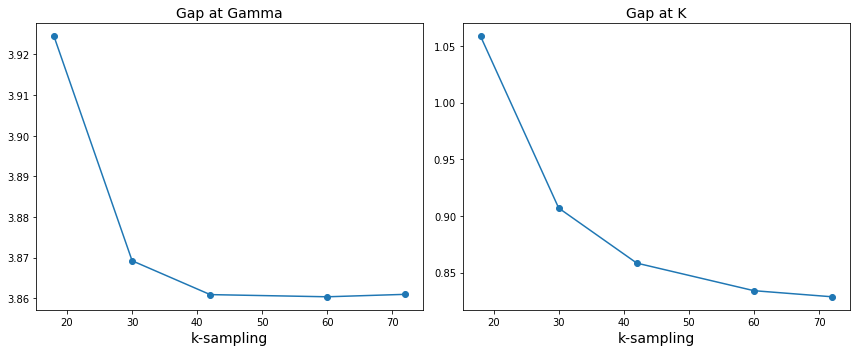

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('k-sampling',size=14)
fig.tight_layout()

With the 60x60x1 sampling the HF gap both at $\Gamma$ and at $K$ is converged at
the level of 5 meV.

## Plasmon pole analysis

We study the convergence of the gap at $\Gamma$ and at $K$ using the plasmon pole run level. 

The aim of this analysis is to find a converged expression for the screening (that will be used also in the BSE calculations)
and to test the RIM_W.

### Convergence analysis of the screening

We use the 18x18x1 k-points sampling and perform a convergence analysis in the BndsRnXp and GbndRnge parameters
needed to compute the screening function.

We perform this analysis using the RIM_W with RandGvecW=10.

In [11]:
input_dir = 'DFT_analysis/kpoints_18-nbnds_500.save'
run_dir = 'MB_analysis/kpoints_18-nbnds_500'
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder GW_analysis-ONCV/kpoints_18-nbnds_500/SAVE already present. No operations performed.


We the define the input variables common to all the runs

In [38]:
ntasks_c = 32 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 28,29
Gamma_index, K_index = 1, 37
RandGvec = 200
RandGvecW = 10
Randqpts = 5e6

EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.activate_RIM_W()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs) 
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

32 2


First we run over NGsBlkXp

In [43]:
NGsBlkXp = [4.0,6.0,8.0,10.] # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,300] # Bands in the response function
GbndRnge = [1,300]  # Bands in the Sigma_c

inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for ngsblkxp in NGsBlkXp:
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=ngsblkxp)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G','ndb_dipoles-nbnds_500',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])],reformat=False)
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_dipoles-nbnds_500',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])],reformat=False)

Initialize a Dataset with 4 parallel tasks


In [44]:
#study.runs[6]

In [45]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7]] 

Run the task [0, 1, 2, 3] 
Skip the run of pp-G-ngsblkxp_4.0-bndsrnxp_300-gbndrnge_300Skip the run of
 pp-K-ngsblkxp_4.0-bndsrnxp_300-gbndrnge_300
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300Skip the run of
 pp-G-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300
Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300
Skip the run of pp-G-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_300
run command: mpirun -np 64 yambo -F pp-K-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_300.in -J "pp-K-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_300,ndb_rim_cutoff,ndb_hf_K,ndb_dipoles-nbnds_500,ndb_em1d-ngsblkxp_10.0-bndsrnxp_300" -C pp-K-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_300
slurm submit:  cd GW_analysis-ONCV/kpoints_18-nbnds_500 ; sbatch job_pp-K-ngsblkxp_10.0-bndsrnxp_300-gbndrnge_300.sh
computation p

In [46]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([0.799132, 0.800351, 0.797613, 0.795936],
 [0.176307, 0.17599200000000004, 0.17595700000000003, 0.175966])

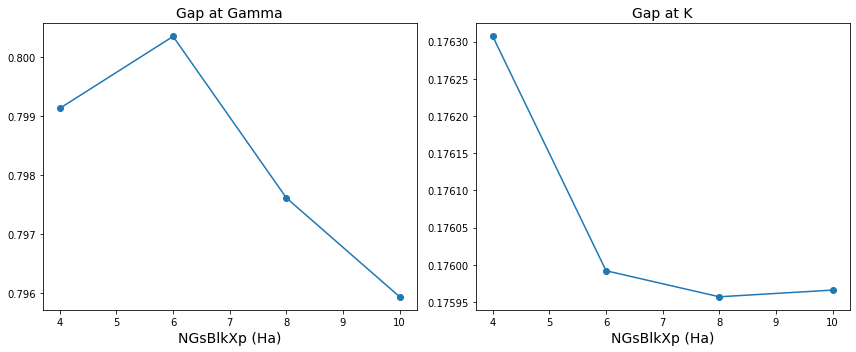

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(NGsBlkXp,gap_G)
axes[0].scatter(NGsBlkXp,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].plot(NGsBlkXp, gap_K)
axes[1].scatter(NGsBlkXp,gap_K)
axes[1].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We choose the value NGsBlkXp = 8 Ha that ensures convergence at the level of 1 meV (or better) for
both the $\Gamma$ and the K points.

Next, we perform a convergence analysis on the number of bands. Here we choose to analyze the combined 
effect of the BndsRnXp and of the GbndRnge parameters. So we iterate over both the parameters.

In [56]:
NGsBlkXp = 8.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
Bands  = [[1,300],[1,400],[1,500]] # Bands in the response function and in the Sigma_c

inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bands in Bands:
    inp.set_array_variables(BndsRnXp=bands)
    inp.set_array_variables(GbndRnge=bands)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bands[1],bands[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G','ndb_dipoles-nbnds_500',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bands[1])],reformat=False) 
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bands[1],bands[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K','ndb_dipoles-nbnds_500',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bands[1])],reformat=False) 

Initialize a Dataset with 1 parallel tasks


In [54]:
#study.runs[2]

In [57]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0], [1], [2], [3], [4], [5]] 

Run the task [0] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300
Task [0] ended 
 
Run the task [1] 
Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300
Task [1] ended 
 
Run the task [2] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400
Task [2] ended 
 
Run the task [3] 
run command: mpirun -np 64 yambo -F pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400.in -J "pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400,ndb_rim_cutoff,ndb_hf_K,ndb_dipoles-nbnds_500,ndb_em1d-ngsblkxp_8.0-bndsrnxp_400" -C pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400
slurm submit:  cd GW_analysis-ONCV/kpoints_18-nbnds_500 ; sbatch job_pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400.sh
computation pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400 is running...
computation pp-K-ngsblkxp_8.0-bndsrnxp_400-gbndrnge_400 ended
Run performed in 14m-54s
Task [3] ended 
 
Run the task [4] 
Skip the run of pp-G-ngsb

In [58]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([0.797613, 0.792634, 0.789345],
 [0.17595700000000003, 0.18112499999999998, 0.18471400000000004])

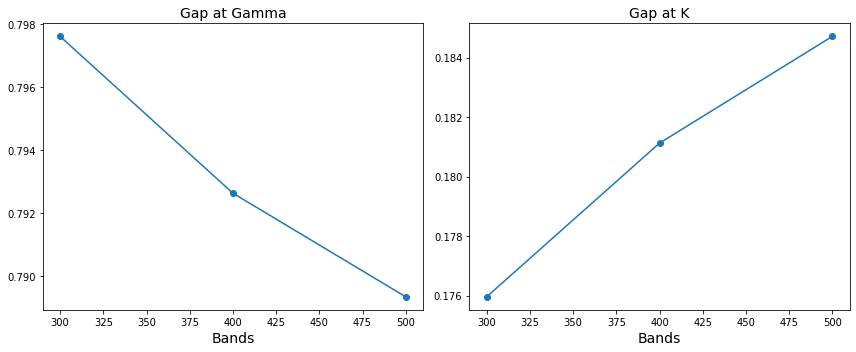

In [59]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(x_vals,gap_G)
axes[0].scatter(x_vals,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('Bands',size=14)
axes[1].plot(x_vals, gap_K)
axes[1].scatter(x_vals,gap_K)
axes[1].set_xlabel('Bands',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

On the basis of this analysis we conclude that NGsBlkXp = 8 Ha, BndsRnXp = GbndRnge = 500 seems to ensure
 convergence within 5 meV.

### PP Analysis in function of the k-points sampling

We test the convergence of the PP gap at $K$ and at the $\Gamma$ points in function of the dimension of the $k$-points sampling.

Note that this analysis is performed without the BG terminator, since we have understood that usage of this terminator is not useful and may lead to erroneous results at $\Gamma$. 

In [4]:
kpoints = [18,42,60,72]

In [5]:
ntasks_c = 16 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 28,29
Gamma_index = {18:1,30:1,42:1,60:1,72:1}
K_index = {18:37,30:91,42:169,60:331,72:469}
RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 60. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 8.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,500]# Bands in the response function
GbndRnge = [1,500] # Bands in the Sigma_c

study = D.Dataset(num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    input_dir = 'DFT_analysis-ONCV/kpoints_%s-nbnds_500.save'%k
    run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_500'%k
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)
    #Tools.build_r_setup(yambo_dir=run_dir)
    #Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir,
    #       p2y_command='mpirun -np 1 p2y',yambo_command='mpirun -np 1 yambo')

    inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
    inp.set_extendOut()
    inp.activate_RIM_W()
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_bandRange(start_band,stop_band)
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
    inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
    #inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 16 nodes on m100
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
    
    # append run at G
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    idd = 'pp-G-kpoints_%s'%k
    jobname = [idd,'ndb_rim_cutoff','ndb_hf_G',
               'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),'ndb_dipoles-nbnds_500']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname,reformat=False)
    # append run at K
    inp.set_kRange(K_index[k],K_index[k])
    idd = 'pp-K-kpoints_%s'%k
    jobname = [idd,'ndb_rim_cutoff','ndb_hf_K',
               'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),'ndb_dipoles-nbnds_500']
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=jobname,reformat=False)

16 4
Initialize a Dataset with 4 parallel tasks
The input directory DFT_analysis-ONCV/kpoints_18-nbnds_500.save  does not exists.
SAVE folder GW_analysis-ONCV/kpoints_18-nbnds_500/SAVE already present. No operations performed.
SAVE folder GW_analysis-ONCV/kpoints_42-nbnds_500/SAVE already present. No operations performed.
SAVE folder GW_analysis-ONCV/kpoints_60-nbnds_500/SAVE already present. No operations performed.
SAVE folder GW_analysis-ONCV/kpoints_72-nbnds_500/SAVE already present. No operations performed.


In [6]:
study.ids

['pp-G-kpoints_18',
 'pp-K-kpoints_18',
 'pp-G-kpoints_42',
 'pp-K-kpoints_42',
 'pp-G-kpoints_60',
 'pp-K-kpoints_60',
 'pp-G-kpoints_72',
 'pp-K-kpoints_72']

In [27]:
#study.runs[4]

In [7]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7]] 

Run the task [0, 1, 2, 3] 
Skip the run of Skip the run ofpp-G-kpoints_18 
pp-K-kpoints_18
Skip the run of pp-K-kpoints_42
Skip the run of pp-G-kpoints_42
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of Skip the run ofpp-K-kpoints_60 
pp-K-kpoints_72Skip the run of
 pp-G-kpoints_60
Skip the run of pp-G-kpoints_72
Task [4, 5, 6, 7] ended 
 


In [8]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G,gap_K = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_G,gap_K

([0.789427, 0.875483, 0.889825, 0.8921429999999999],
 [0.18476900000000002, 0.183423, 0.18503199999999997, 0.18470999999999999])

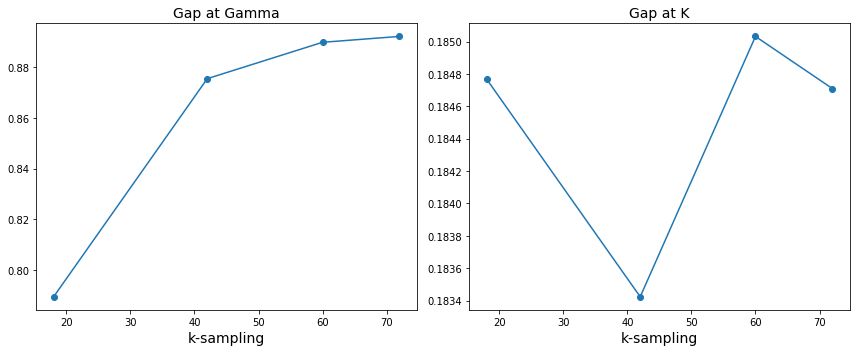

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_xlabel('k-sampling',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We conclude that the value
$$
E_{gap} = 184 meV
$$
is the best estimate of the gap of the Stanene at K

## Quasi-particle band structure

We use the convergence test performed above to computed the GW correction in the whole BZ. 
In this way we can compute the quasi-particle correction of the band structure.

At this level of the analysis we perform these computations for the 30x30x1 $k$-points samplings.

In [119]:
kpoints = 42 #42 #60
run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_500'%kpoints

In [6]:
ntasks_c = 32
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 25,32
RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'
NGsBlkXp = 8.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,500]# Bands in the response function
GbndRnge = [1,500] # Bands in the Sigma_c

inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.activate_RIM_W()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_bandRange(start_band,stop_band)
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
#inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 16 nodes on m100
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

32 1


In [ ]:
idd = 'pp-allBZ-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,BndsRnXp[1],GbndRnge[1])
jobname = [idd,'ndb_rim_cutoff','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1]),
           'ndb_dipoles-nbnds_500','ndb_hf_allBZ']
results = code.run(input=inp,run_dir=run_dir,name=idd,jobname=jobname,reformat=False)

run command: mpirun -np 64 --map-by socket:PE=8 --rank-by core yambo -F pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500.in -J "pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500,ndb_rim_cutoff,ndb_em1d-ngsblkxp_8.0-bndsrnxp_500,ndb_dipoles-nbnds_500,ndb_hf_allBZ" -C pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500
slurm submit:  cd GW_analysis-ONCV/kpoints_60-nbnds_500 ; sbatch job_pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500.sh
computation pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500 is running...


### Ypp analysis

We use the previous results to compute the GW correction of the band structure along a high symmetry path.

In [7]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
ypp_code = C.YamboCalculator(rr,executable='ypp',activate_BeeOND=False,dry_run=True) 
ypp_code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '124000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'ypp',
 'skip': True,
 'clean_restart': True,
 'dry_run': True,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

In [120]:
ndbQP = 'pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500/ndb.QP'

In [121]:
# with BANDS_kpts

band_range = [start_band,stop_band]
bands_step = 50

# in crystal coordinates
G = [0.,0.,0.]
Kp = [1./3.,1./3.,0.]
Mp = [0.,0.5,0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path
path = [G,Mp,Kp,G]

study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)

inp = I.YamboInput(args='mpirun -np 1 ypp -s b -V qp',folder=run_dir,filename='ypp.in')
inp.set_array_variables(BANDS_bands=band_range,BANDS_steps=bands_step,BANDS_kpts=path)
#inp.set_array_variables(GfnQP_E=GfnQP_E[k])
inp.set_scalar_variables(cooIn='rlu',cooOut='rlu')

idd = 'ypp_bands_dft_boltz'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [30,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [30,'']
study.append_run(id=idd,input=inp,runner=ypp_code) 

idd = 'ypp_bands_gw_boltz'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [30,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [30,'']
inp['variables']['GfnQPdb']= 'E < %s'%ndbQP
study.append_run(id=idd,input=inp,runner=ypp_code)

Initialize a Dataset with 2 parallel tasks


In [122]:
#study.runs[1]

In [123]:
results = study.run() #selection=[1],skip=False

Run the selection [0, 1] with the parallel task_groups [[0, 1]] 

Run the task [0, 1] 
Skip the run of ypp_bands_dft_boltz
Skip the run of ypp_bands_gw_boltz
Task [0, 1] ended 
 


In [124]:
bands_gw = U.BandStructure.from_Ypp(results[1],high_sym,suffix='bands_interpolated')
bands_dft = U.BandStructure.from_Ypp(results[0],high_sym,suffix='bands_interpolated')

We show the GW correction for the valence and conduction bands

0.1850489003682173


(-0.4, 0.6)

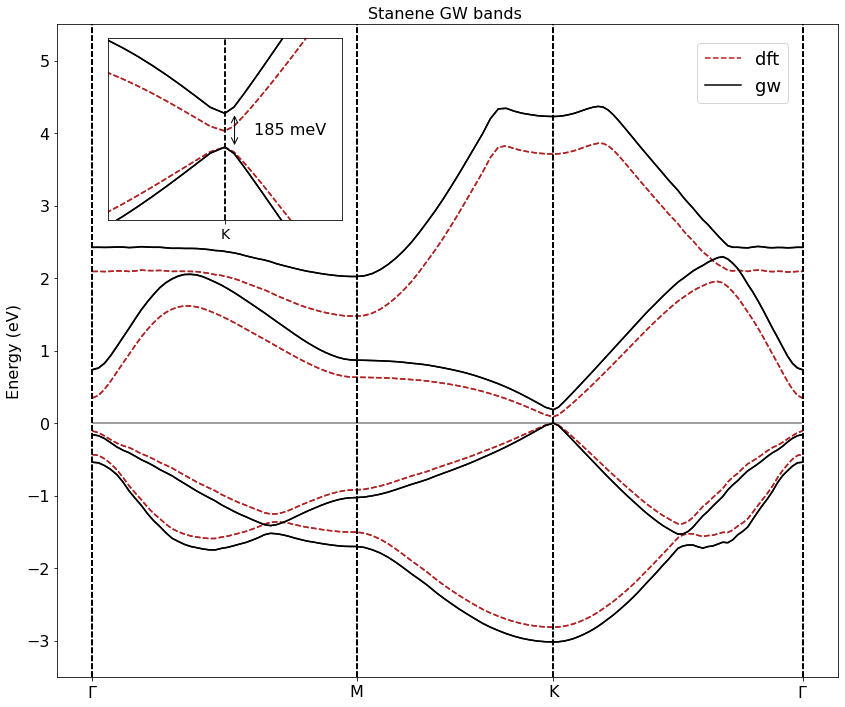

In [99]:
# Results for the 60x60x1 kpoints sampling 30 interp shells

from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
K_position = bands_dft.get_high_sym_positions()[1][2]
shift = 0.12
gap = min(bands_gw.bands[4])-max(bands_gw.bands[3])
print(gap)

fig, ax1 = plt.subplots(figsize=(14,12))
bands_dft.plot(plt,axes=ax1,selection=[0],linestyle='--',label='dft',c='firebrick')
bands_dft.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='--',c='firebrick')
bands_gw.plot(plt,axes=ax1,selection=[0],linestyle='-',label='gw',c='black')
bands_gw.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='-',c='black')
ax1.hlines(0.,0.,1.344,linestyles='-',color='gray')
ax1.set_ylim(-3.5,5.5)
ax1.set_ylabel('Energy (eV)',size=16)
ax1.set_title('Stanene GW bands ',size=16)
ax1.legend(loc=(0.82,0.88),fontsize=18,frameon=True)
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.065,0.7,0.3,0.28])
ax2.set_axes_locator(ip)
bands_dft.plot(plt,axes=ax2,selection=[2,3,4,5],linestyle='--',c='firebrick')
bands_gw.plot(plt,axes=ax2,selection=[2,3,4,5],linestyle='-',c='black')
ax2.annotate('', xy=(K_position+0.01, 0), xytext=(K_position+0.01, gap), arrowprops=dict(arrowstyle='<->'),size=16)
ax2.text(K_position+0.03,0.07,'185 meV',size=16)
ax2.set_yticks([])
ax2.set_xlim(K_position-shift,K_position+shift)
ax2.set_ylim(-0.4,0.6)

#plt.savefig(fname='Plot/Stanene-band_structure-kpoints_%s.eps'%kpoints,format='eps',bbox_inches = "tight")

0.1834212877588


(-0.4, 0.6)

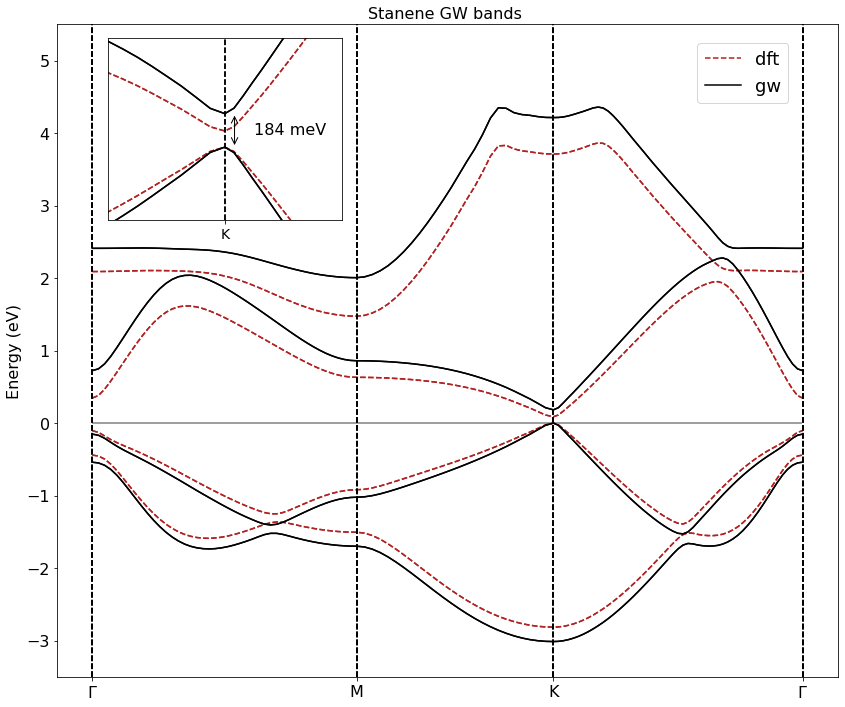

In [127]:
# Results for the 42x42x1 kpoints sampling 20 interp shells

from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
K_position = bands_dft.get_high_sym_positions()[1][2]
shift = 0.12
gap = min(bands_gw.bands[4])-max(bands_gw.bands[3])
print(gap)

fig, ax1 = plt.subplots(figsize=(14,12))
bands_dft.plot(plt,axes=ax1,selection=[0],linestyle='--',label='dft',c='firebrick')
bands_dft.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='--',c='firebrick')
bands_gw.plot(plt,axes=ax1,selection=[0],linestyle='-',label='gw',c='black')
bands_gw.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='-',c='black')
ax1.hlines(0.,0.,1.344,linestyles='-',color='gray')
ax1.set_ylim(-3.5,5.5)
ax1.set_ylabel('Energy (eV)',size=16)
ax1.set_title('Stanene GW bands ',size=16)
ax1.legend(loc=(0.82,0.88),fontsize=18,frameon=True)
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.065,0.7,0.3,0.28])
ax2.set_axes_locator(ip)
bands_dft.plot(plt,axes=ax2,selection=[2,3,4,5],linestyle='--',c='firebrick')
bands_gw.plot(plt,axes=ax2,selection=[2,3,4,5],linestyle='-',c='black')
ax2.annotate('', xy=(K_position+0.01, 0), xytext=(K_position+0.01, gap), arrowprops=dict(arrowstyle='<->'),size=16)
ax2.text(K_position+0.03,0.07,'184 meV',size=16)
ax2.set_yticks([])
ax2.set_xlim(K_position-shift,K_position+shift)
ax2.set_ylim(-0.4,0.6)

#plt.savefig(fname='Plot/Stanene-band_structure-kpoints_%s.eps'%kpoints,format='eps',bbox_inches = "tight")

0.18478119531367618


(-0.4, 0.6)

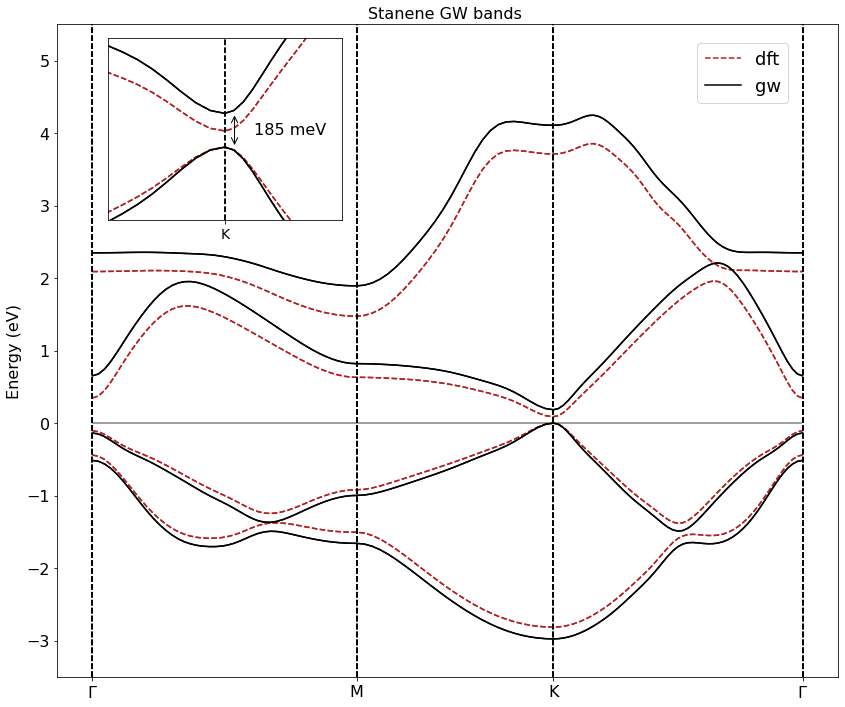

In [118]:
# Results for the 18x18x1 kpoints sampling 10 inter shells

from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
K_position = bands_dft.get_high_sym_positions()[1][2]
shift = 0.12
gap = min(bands_gw.bands[4])-max(bands_gw.bands[3])
print(gap)

fig, ax1 = plt.subplots(figsize=(14,12))
bands_dft.plot(plt,axes=ax1,selection=[0],linestyle='--',label='dft',c='firebrick')
bands_dft.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='--',c='firebrick')
bands_gw.plot(plt,axes=ax1,selection=[0],linestyle='-',label='gw',c='black')
bands_gw.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='-',c='black')
ax1.hlines(0.,0.,1.344,linestyles='-',color='gray')
ax1.set_ylim(-3.5,5.5)
ax1.set_ylabel('Energy (eV)',size=16)
ax1.set_title('Stanene GW bands ',size=16)
ax1.legend(loc=(0.82,0.88),fontsize=18,frameon=True)
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.065,0.7,0.3,0.28])
ax2.set_axes_locator(ip)
bands_dft.plot(plt,axes=ax2,selection=[2,3,4,5],linestyle='--',c='firebrick')
bands_gw.plot(plt,axes=ax2,selection=[2,3,4,5],linestyle='-',c='black')
ax2.annotate('', xy=(K_position+0.01, 0), xytext=(K_position+0.01, gap), arrowprops=dict(arrowstyle='<->'),size=16)
ax2.text(K_position+0.03,0.07,'185 meV',size=16)
ax2.set_yticks([])
ax2.set_xlim(K_position-shift,K_position+shift)
ax2.set_ylim(-0.4,0.6)

#plt.savefig(fname='Plot/Stanene-band_structure-kpoints_%s.eps'%kpoints,format='eps',bbox_inches = "tight")